In [4]:
%reset 


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [265]:
%run  ./Kickit_app_transformers.py

In [328]:

#from Kickit_app_transformers import Kickit_dataframe_preprocessor
#from Kickit_app_transformers import Kickit_frequency_encoder
#from Kickit_app_transformers import Kickit_weight_of_evidence_encoder
#from Kickit_app_transformers import  Kickit_dataframe_balancer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Reading the Data set

In [329]:
# reading the dataset
df_raw = pd.read_csv('kick.csv')
df_raw.head(2)

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,...,11597,12409,?,?,21973,33619,FL,7100,0,1113
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,11374,12791,?,?,19638,33619,FL,7600,0,1053


Extracting the axis of studies for the project custom to  ADESA website 

In [330]:
choosen_axis = ["Model", "Make" ,"Transmission","VehOdo","MMRAcquisitionAuctionAveragePrice", "IsBadBuy"]
df_adesa_raw = df_raw[choosen_axis]

df_adesa_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Model                              72983 non-null  object
 1   Make                               72983 non-null  object
 2   Transmission                       72983 non-null  object
 3   VehOdo                             72983 non-null  int64 
 4   MMRAcquisitionAuctionAveragePrice  72983 non-null  object
 5   IsBadBuy                           72983 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


# Pre-processing Pipeline for the freqency encoding technique

copying the raw data

In [331]:
df = df_adesa_raw.copy()

 Instantiating the preprocessing pipeline objects

In [332]:
# this on will clean the data with respect to our strategy
f_preprocess = Kickit_dataframe_preprocessor()
# this one will balance the dataset
f_balancer = Kickit_dataframe_balancer()
# this one will use the frequency encoding technique for categorical variable 
freq_encoder = Kickit_frequency_encoder()

Creating a pipeline for the first preprocessing technique :based on count of  frequency encoder

In [333]:
freq_pipeline = Pipeline([("preprocess",f_preprocess),("balancer", f_balancer),
                          ("fencoder",freq_encoder)])

preprocessing the dataframe with the count of frequency pipeline

In [334]:
adesa_freq_pipe = freq_pipeline.fit_transform(df)

checking the transformation for success

In [335]:
adesa_freq_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy
0,42,267,17137,89046,8155.0,0
1,230,2923,17137,93593,6854.0,0
2,138,2923,17137,73807,3202.0,0
3,135,2923,17137,65617,1893.0,0
4,244,2977,586,69367,3913.0,0


In [336]:
adesa_freq_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17724 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              17724 non-null  int64  
 1   Make                               17724 non-null  int64  
 2   Transmission                       17724 non-null  int64  
 3   VehOdo                             17724 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  17724 non-null  float64
 5   IsBadBuy                           17724 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 830.9 KB


###  Modelization based on frequency count

 preparing and spliting the dataset for the modelization

In [337]:
features = adesa_freq_pipe.drop("IsBadBuy", axis =1)
target = adesa_freq_pipe["IsBadBuy"]
x_ftrain, x_ftest, y_ftrain, y_ftest = train_test_split(features, target, test_size=0.25, random_state=0)

Creating a list of pipelines for three different candidate classifiers 

In [338]:
f_scaler = StandardScaler()
f_randomForest = RandomForestClassifier()
f_logisticRegr = LogisticRegression(random_state=0)
f_decisionTree = DecisionTreeClassifier()

freq_bench_cross = [Pipeline([("scaler",f_scaler), ('lr_classifier', f_logisticRegr)]),
                    Pipeline([('dt_classifier', f_decisionTree)]),
                    Pipeline([('rf_classifier', f_randomForest)])] 

In [339]:
# Dictionary of pipelines and classifier types for ease of reference
freq_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in freq_bench_cross:
    pipe.fit(x_ftrain, y_ftrain)

In [340]:
for i,model in enumerate(freq_bench_cross):
    print("{} with count of frequency Test Accuracy: {}".format(freq_pipe_dict[i],model.score(x_ftest,y_ftest)))

Logistic Regression with count of frequency Test Accuracy: 0.5899345520198601
Decision Tree with count of frequency Test Accuracy: 0.5538253215978335
RandomForest with count of frequency Test Accuracy: 0.590611600090273


# Pipelines for the Weight of Evidence  encoding technique

### Preprocessing the dataframe with the weight of evidence pipeline

In [341]:
df = df_adesa_raw.copy()

 Instantiating the pipeline object

In [342]:
# this on will clean the data with respect to our requirements
w_preprocess = Kickit_dataframe_preprocessor()
# this one will balance the dataset
w_balancer = Kickit_dataframe_balancer()
# # this one will use the weight of evidence encoding technique for categorical variable 
woe_encoder = Kickit_weight_of_evidence_encoder()

#Creating a pipeline for the second  preprocessing technique :based on the weight of evidence encoder

In [343]:
woe_pipeline = Pipeline([("preprocess",w_preprocess),("balancer", w_balancer),
                         ("woe_encoder", woe_encoder),("2nd balancer", w_balancer)])

preprocessing the dataframe with the weight of evidence pipeline

In [344]:
# the next command  after this will raise an unecessary warning message, this will help keep the notebook clean
warnings.filterwarnings('ignore')

In [345]:
adesa_woe_pipe = woe_pipeline.fit_transform(df)

In [346]:
adesa_woe_pipe['IsBadBuy'].sum()

8180

In [347]:
# checking results
adesa_woe_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded,Transmission_encoded
0,MAZDA3,MAZDA,AUTO,89046,8155.0,0,0.376478,-0.256720,0.027895
1,1500 RAM PICKUP 2WD,DODGE,AUTO,93593,6854.0,0,-0.156161,0.199403,0.027895
2,STRATUS V6,DODGE,AUTO,73807,3202.0,0,0.499331,0.199403,0.027895
3,NEON,DODGE,AUTO,65617,1893.0,0,-0.590075,0.199403,0.027895
4,FOCUS,FORD,MANUAL,69367,3913.0,0,-0.570053,-0.288186,-0.015355


In [348]:

woe_cat_dict.get('DODGE')

0.19940286644922028

In [349]:
woe_cat_dict.get('MAZDA')

-0.25671984684781396

In [350]:
woe_cat_dict.get('MAZDA3')

0.37647757123491205

In [351]:
# Checking the dictionary from our encoding class created for each category
woe_cat_dict

{'1500 RAM PICKUP 2WD': -0.15616073075528253,
 '1500 RAM PICKUP 4WD': -0.3677247801253174,
 '1500 SIERRA PICKUP 2': 0.4895482253187058,
 '1500 SILVERADO PICKU': 0.7073318155519017,
 '2500 RAM PICKUP 2WD': -0.5108256237659907,
 '2500HD SILVERADO PIC': -0.587786664902119,
 '300': 0.8226812327518476,
 '300 2.7L V6 MPI': 1.0986122886681098,
 '300M': -1.0986122886681098,
 '300M 3.5L V6 MPI': -0.8472978603872037,
 'ACCENT': -0.04348511193973878,
 'ACCENT 1.6L I4 MPI': -0.4228568508200336,
 'ACCORD 4C': 0.5877866649021191,
 'ACCORD 4C 2.4L I-4 M': 0.8472978603872037,
 'ACCORD V6': 0.8209805520698303,
 'ACCORD V6 3.0L V6 EF': 0.5877866649021191,
 'ALERO 4C': 0.14842000511827322,
 'ALERO 4C 2.2L I4 MPI': -0.7884573603642702,
 'ALERO V6': -1.466337068793427,
 'ALERO V6 3.4L V6 MPI': -0.6359887667199967,
 'ALTIMA': 0.17010596902583072,
 'ALTIMA 2.5L I4 EFI': -0.9382696385929302,
 'ALTIMA 2.5L I4 MPI': 0.23180161405732438,
 'AMANTI': 0.5877866649021191,
 'AMANTI 3.5L V6 MPI': -0.25131442828090605,

In [352]:
woe_cat_dict 
#the nan value are here can simply be compared to having no values or zero, we will set it in the flask code part
# using the np.nan_to_num method

{'1500 RAM PICKUP 2WD': -0.15616073075528253,
 '1500 RAM PICKUP 4WD': -0.3677247801253174,
 '1500 SIERRA PICKUP 2': 0.4895482253187058,
 '1500 SILVERADO PICKU': 0.7073318155519017,
 '2500 RAM PICKUP 2WD': -0.5108256237659907,
 '2500HD SILVERADO PIC': -0.587786664902119,
 '300': 0.8226812327518476,
 '300 2.7L V6 MPI': 1.0986122886681098,
 '300M': -1.0986122886681098,
 '300M 3.5L V6 MPI': -0.8472978603872037,
 'ACCENT': -0.04348511193973878,
 'ACCENT 1.6L I4 MPI': -0.4228568508200336,
 'ACCORD 4C': 0.5877866649021191,
 'ACCORD 4C 2.4L I-4 M': 0.8472978603872037,
 'ACCORD V6': 0.8209805520698303,
 'ACCORD V6 3.0L V6 EF': 0.5877866649021191,
 'ALERO 4C': 0.14842000511827322,
 'ALERO 4C 2.2L I4 MPI': -0.7884573603642702,
 'ALERO V6': -1.466337068793427,
 'ALERO V6 3.4L V6 MPI': -0.6359887667199967,
 'ALTIMA': 0.17010596902583072,
 'ALTIMA 2.5L I4 EFI': -0.9382696385929302,
 'ALTIMA 2.5L I4 MPI': 0.23180161405732438,
 'AMANTI': 0.5877866649021191,
 'AMANTI 3.5L V6 MPI': -0.25131442828090605,

In [353]:
adesa_woe_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16360 entries, 0 to 16359
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              16360 non-null  object 
 1   Make                               16360 non-null  object 
 2   Transmission                       16360 non-null  object 
 3   VehOdo                             16360 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  16360 non-null  float64
 5   IsBadBuy                           16360 non-null  int64  
 6   Model_encoded                      16360 non-null  float64
 7   Make_encoded                       16360 non-null  float64
 8   Transmission_encoded               16360 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 1.1+ MB


### Modelization based on WOE 

In [354]:
df = df_adesa_raw.copy()

In [355]:
#features = df
#target = df["IsBadBuy"]

#x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify =df['Make']  )

In [356]:
y_wtrain.value_counts()

0    6168
1    6102
Name: IsBadBuy, dtype: int64

In [357]:
y_wtest.value_counts()

1    2078
0    2012
Name: IsBadBuy, dtype: int64

In [358]:
#features = df
#target = df["IsBadBuy"]
#x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify = )

In [359]:
features = adesa_woe_pipe
target = adesa_woe_pipe["IsBadBuy"]
x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0)

In [360]:
x_wtrain["IsBadBuy"].shape[0]

12270

In [361]:
x_wtrain["IsBadBuy"].shape[0]

12270

In [362]:
w_scaler = StandardScaler()
w_randomForest = RandomForestClassifier(class_weight="balanced")
w_logisticRegr = LogisticRegression(random_state=0)
w_decisionTree = DecisionTreeClassifier()

# Creating a list of pipelines for three different candidate classifiers 
woe_bench_cross = [Pipeline([("scaler",w_scaler), ('lr_classifier', w_logisticRegr)]),
                    Pipeline([('dt_classifier', w_decisionTree)]),
                    Pipeline([('rf_classifier', w_randomForest)])] 

In [363]:
x_wtrain

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded,Transmission_encoded
3824,IMPALA,CHEVROLET,AUTO,61255,6840.0,0,0.473546,0.352315,0.027895
12190,TAURUS 3.0L V6 EFI,FORD,AUTO,61718,4495.0,1,-0.462272,-0.288186,0.027895
4075,TRAILBLAZER EXT 2WD,CHEVROLET,AUTO,78986,5490.0,0,0.197359,0.352315,0.027895
4350,UPLANDER FWD V6 3.5L,CHEVROLET,AUTO,67555,7123.0,0,0.570545,0.352315,0.027895
11031,SORENTO 2WD,KIA,AUTO,69046,5058.0,1,-1.189584,0.070569,0.027895
...,...,...,...,...,...,...,...,...,...
13123,EXPLORER 4WD V6,FORD,AUTO,75445,6788.0,1,-0.587787,-0.288186,0.027895
3264,PT CRUISER 2.4L I4 S,CHRYSLER,AUTO,41735,6263.0,0,-0.241552,-0.161349,0.027895
9845,TRAILBLAZER 2WD 6C 4,CHEVROLET,AUTO,71891,6434.0,1,0.198177,0.352315,0.027895
10799,GRAND PRIX 3.8L V6 S,PONTIAC,AUTO,78448,6699.0,1,0.688463,0.106768,0.027895


In [364]:
# Dictionary of pipelines and classifier types for ease of reference
woe_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: ' Default mode RandomForest'}

# Fit the pipelines
for pipe in woe_bench_cross:
    pipe.fit(x_wtrain.drop(["IsBadBuy", "Model", "Make","Transmission"], axis =1), y_wtrain)

In [365]:
for i,model in enumerate(woe_bench_cross):
    print("{} with Weight of evidence Test Accuracy: {}".format(woe_pipe_dict[i],model.score(x_wtest.drop(["IsBadBuy", "Model", "Make","Transmission"], axis =1),y_wtest)))

Logistic Regression with Weight of evidence Test Accuracy: 0.628361858190709
Decision Tree with Weight of evidence Test Accuracy: 0.5603911980440098
 Default mode RandomForest with Weight of evidence Test Accuracy: 0.5965770171149144


# Random frorest classifier Auto-Hyperparameters tuning

In [366]:
# Create a pipeline
pipe = make_pipeline((RandomForestClassifier()))
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier(class_weight="balanced")],
                 "randomforestclassifier__n_estimators": [10],
                 "randomforestclassifier__max_depth":[10,30,25,20],
                 "randomforestclassifier__min_samples_leaf":[1,2,5,6,10,15,100],
                 "randomforestclassifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=10, verbose=0,n_jobs=-1) # Fit grid search
Upgraded_Random_frorest = gridsearch.fit(x_wtrain.drop(["IsBadBuy", "Model", "Make","Transmission"], axis =1),y_wtrain)

In [367]:
Upgraded_Random_frorest.score(x_wtest.drop(["IsBadBuy", "Model", "Make","Transmission"], axis =1), y_wtest)

0.6207823960880196

In [368]:
print(Upgraded_Random_frorest.best_estimator_)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        max_leaf_nodes=10, min_samples_leaf=100,
                                        n_estimators=10))])


# Results

The best pipeline between the frequency encoding and the weight of evidence encoding is  : Weight of evidence one 

The best model within that pipeline is : Logistic regression  then Upgraded Random forest models with the same score

saving the created encoding dictionnary for interpretation in the flask part

In [369]:
file = open('kidict.pkl', 'wb')
pickle.dump(woe_cat_dict, file)

saving the selected model

In [370]:
file = open('model.pkl', 'wb')
pickle.dump(Upgraded_Random_frorest, file)

# Test

In [371]:
a = Upgraded_Random_frorest.predict(x_wtest.drop(["IsBadBuy",
                                                  "Model",
                                                  "Make",
                                                  "Transmission"], axis =1))
a

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [372]:
len(a)

4090

In [373]:
a.sum()

1975

In [374]:
x_wtest['predicted_label'] = Upgraded_Random_frorest.predict(x_wtest.drop(["IsBadBuy",
                                                                           "Model", 
                                                                           "Make",
                                                                           "Transmission"], axis =1))

In [375]:
x_wtest.head(5) 


,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded,Transmission_encoded,predicted_label
12540,ALTIMA,NISSAN,AUTO,86450,4165.0,1,0.170106,-0.244453,0.027895,1
2606,VENTURE FWD V6,CHEVROLET,AUTO,78136,3382.0,0,-0.072759,0.352315,0.027895,1
5911,CAVALIER 4C,CHEVROLET,AUTO,50887,2977.0,0,-0.463837,0.352315,0.027895,1
7862,CALIBER,DODGE,AUTO,90387,7197.0,0,-0.489548,0.199403,0.027895,1
1534,TAURUS,FORD,AUTO,71364,2259.0,0,-0.029632,-0.288186,0.027895,1


In [376]:
woe_cat_dict.get('IMPALA')

0.47354624267324213

In [377]:
test['IsBadBuy'].sum()

2078

In [406]:
test = x_wtest.drop(["Model_encoded", "Make_encoded","Transmission_encoded"], axis =1)
test.head(20)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
12540,ALTIMA,NISSAN,AUTO,86450,4165.0,1,1
2606,VENTURE FWD V6,CHEVROLET,AUTO,78136,3382.0,0,1
5911,CAVALIER 4C,CHEVROLET,AUTO,50887,2977.0,0,1
7862,CALIBER,DODGE,AUTO,90387,7197.0,0,1
1534,TAURUS,FORD,AUTO,71364,2259.0,0,1
574,COBALT,CHEVROLET,MANUAL,88170,5092.0,0,1
10172,STRATUS V6,DODGE,AUTO,64554,3228.0,1,0
14897,DURANGO 4WD V8 4.7L,DODGE,AUTO,89416,9116.0,1,0
12148,EXPEDITION 2WD V8,FORD,AUTO,91769,8446.0,1,1
5543,IMPALA,CHEVROLET,AUTO,68515,8015.0,0,0


In [379]:
from sklearn.metrics import confusion_matrix
y_true = test['IsBadBuy']
y_pred = test['predicted_label']
confusion_matrix(y_true, y_pred)

array([[1288,  724],
       [ 827, 1251]], dtype=int64)

In [380]:
test.describe() 
#test[test.MMRAcquisitionAuctionAveragePrice == 0]

,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
count,4090.000000,4090.000000,4090.000000,4090.000000
mean,73238.441809,5781.391443,0.508068,0.482885
std,14078.099940,2365.500054,0.499996,0.499768
min,12628.000000,10.000000,0.000000,0.000000
25%,64135.000000,3880.250000,0.000000,0.000000
50%,74673.000000,5547.500000,1.000000,0.000000
75%,83582.250000,7386.000000,1.000000,1.000000
max,115717.000000,17229.000000,1.000000,1.000000


In [407]:
test.Make.value_counts() #mask for lincoln

CHEVROLET     914
DODGE         722
FORD          708
CHRYSLER      478
PONTIAC       244
NISSAN        128
KIA           122
SATURN        119
HYUNDAI       114
JEEP          101
MERCURY        77
MITSUBISHI     61
SUZUKI         59
BUICK          49
MAZDA          47
TOYOTA         44
GMC            34
HONDA          32
OLDSMOBILE     20
LINCOLN         6
ISUZU           4
SUBARU          2
INFINITI        2
MINI            2
LEXUS           1
Name: Make, dtype: int64

<AxesSubplot:xlabel='Model', ylabel='Density'>

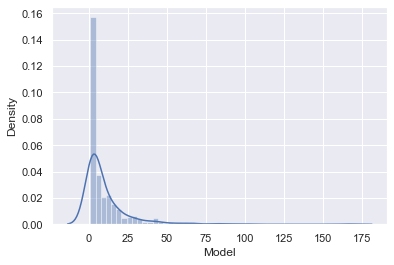

In [408]:
sns.distplot(test.Model.value_counts())

In [60]:
# evaluate the model per car type
# same number of car and model
#same distribution in in the train and test set = train and test stratified (same distribution per categories) , 
#keycode in train test split , double stratification
# apply a Mask , for other, reduce 

#balancing (embe learn  , data augmentation) follows startification.

# pour quel marque ca marche bien 

In [61]:
# EDA + comments

In [223]:
Make_count = test.Make.value_counts()
make_mask = test.Make.isin(Make_count[Make_count < 100].index)
#test.Make[Make_mask] = 'Other Make'

In [96]:
model_count = test.Model.value_counts()
model_mask = test.Model.isin(model_count[model_count < 100].index)
#test.Model[model_mask] = 'Other Model'

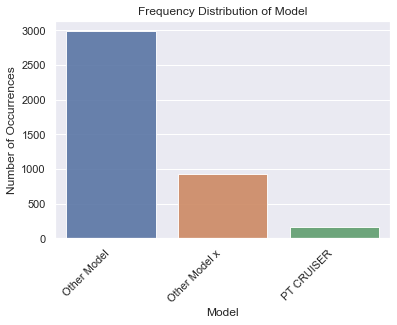

In [98]:
import seaborn as sns
import  matplotlib.pyplot as plt
model_count = test.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [232]:
#!pip install imblearn 
from imblearn.over_sampling import SMOTEC #SMOTE(*, sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None)[source]

ImportError: cannot import name 'SMOTEC' from 'imblearn.over_sampling' (C:\Users\abdou\.conda\envs\kick\lib\site-packages\imblearn\over_sampling\__init__.py)

In [316]:
sm = SMOTEC(random_state=42)
X_res, y_res = sm.fit_resample(test.Make.drop("Make", axis = 1) , test.Make)


NameError: name 'SMOTEC' is not defined

In [282]:
from collections import Counter

In [424]:
counts=Counter(test.Make)
# summarize class distribution

counts

Counter({'NISSAN': 128,
         'CHEVROLET': 914,
         'DODGE': 722,
         'FORD': 708,
         'SATURN': 119,
         'BUICK': 49,
         'KIA': 122,
         'CHRYSLER': 478,
         'MAZDA': 47,
         'HONDA': 32,
         'JEEP': 101,
         'PONTIAC': 244,
         'HYUNDAI': 114,
         'MERCURY': 77,
         'SUZUKI': 59,
         'MITSUBISHI': 61,
         'GMC': 34,
         'TOYOTA': 44,
         'OLDSMOBILE': 20,
         'LINCOLN': 6,
         'ISUZU': 4,
         'SUBARU': 2,
         'INFINITI': 2,
         'MINI': 2,
         'LEXUS': 1})

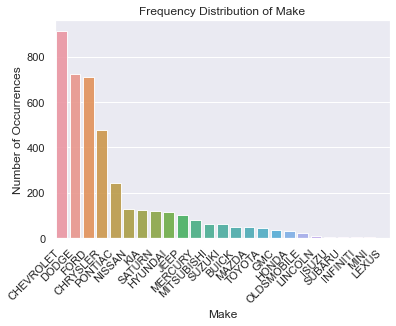

In [425]:
import seaborn as sns
import  matplotlib.pyplot as plt
model_count = test.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

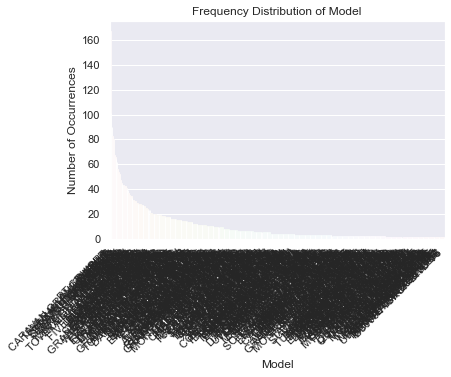

In [426]:
model_count = test.Model.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [427]:
#Call the function on the make column  with a  threshold of 98%
transf_make_column,new_category_list=cumulatively_categorise(test.Make,threshold = 0.98, return_categories_list=True)



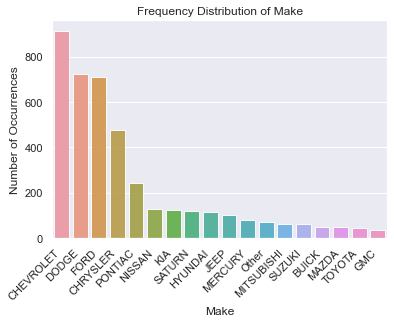

In [428]:
transf_make_column_count = transf_make_column.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(transf_make_column_count.index, transf_make_column_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

In [435]:
#Call the function on the make column  with a  threshold of 80%
transf_model_column,new_category_list=cumulatively_categorise(test.Model,threshold = 0.70, return_categories_list=True)



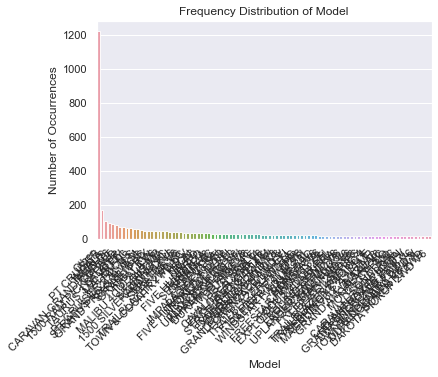

In [436]:
transf_model_column_count = transf_model_column.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(transf_model_column_count.index, transf_model_column_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Model')
plt.ylabel('Number of Occurrences')
plt.xlabel('Model')
plt.show()

In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

#X, y = oversample.fit_resample(X, y)

In [320]:
#convert text data to numeric before applying SMOTE 
from sklearn.feature_extraction.text import CountVectorizer

In [398]:
vectorizer = CountVectorizer()
vectorizer.fit(test.Make.values.ravel())
test.Make = vectorizer.transform(test.Make.values.ravel())


In [405]:
test.Make = test.Make.toarray()
test.Make

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [402]:
vectorizer2 = CountVectorizer()
vectorizer2.fit(test.Model.values.ravel())
test.Model = vectorizer2.transform(test.Model.values.ravel())


AttributeError: values not found

In [403]:
test.Model = test.Model.toarray()
test.Model

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [393]:
vectorizer3 = CountVectorizer()
vectorizer3.fit(test.Transmission.values.ravel())
test.Transmission = vectorizer3.transform(test.Transmission.values.ravel())


In [404]:
test.Transmission = test.Transmission.toarray()
test.Transmission

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [440]:
test.describe()

,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
count,4090.000000,4090.000000,4090.000000,4090.000000
mean,73238.441809,5781.391443,0.508068,0.482885
std,14078.099940,2365.500054,0.499996,0.499768
min,12628.000000,10.000000,0.000000,0.000000
25%,64135.000000,3880.250000,0.000000,0.000000
50%,74673.000000,5547.500000,1.000000,0.000000
75%,83582.250000,7386.000000,1.000000,1.000000
max,115717.000000,17229.000000,1.000000,1.000000


In [388]:



##vectorizer.fit(X_train.values.ravel())
##X_train=vectorizer.transform(X_train.values.ravel())
#X_test=vectorizer.transform(X_test.values.ravel())
#X_train=X_train.toarray()
#X_test=X_test.toarray()
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(test.drop("Make", axis = 1) , test.Make)


ValueError: could not convert string to float: 'ALTIMA'

In [295]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
        #Append the category Other to the list
        categories_list.append('Other')
        #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list == True):
        return new_column,categories_list
        #Return only the transformed column if return_categories=False
    else:
        return new_column



In [303]:
transformed_column.value_counts()

CHEVROLET     914
DODGE         722
FORD          708
CHRYSLER      478
PONTIAC       244
Other         194
NISSAN        128
KIA           122
SATURN        119
HYUNDAI       114
JEEP          101
MERCURY        77
MITSUBISHI     61
SUZUKI         59
BUICK          49
Name: Make, dtype: int64

In [439]:
test[test.Make =="DODGE"].Model.value_counts()

CARAVAN GRAND FWD V6    83
1500 RAM PICKUP 2WD     67
CALIBER                 66
STRATUS V6 2.7L V6 M    52
STRATUS 4C              45
STRATUS V6              37
NEON                    33
NEON 2.0L I4 SFI        27
DURANGO 2WD V8          26
AVENGER 4C              23
STRATUS 4C 2.4L I4 M    21
DURANGO 4WD V8          20
CALIBER 2.0L I4 SFI     19
CHARGER V6              18
MAGNUM V6               17
MAGNUM V6 2.7L V6 MP    16
CARAVAN FWD V6 3.3L     15
DURANGO 2WD V8 4.7L     14
DURANGO 4WD V8 4.7L     14
DAKOTA PICKUP 2WD V6    13
DURANGO 2WD V6          12
CHARGER                 11
CARAVAN FWD 4C          10
CARAVAN FWD V6          10
STRATUS 4C 2.4L I4 S     9
CARAVAN FWD 4C 2.4L      6
CHARGER V6 2.7L V6 M     6
1500 RAM PICKUP 4WD      4
AVENGER 4C 2.4L I4 S     4
DURANGO 2WD V6 3.7L      4
MAGNUM V6 3.5L V6 MP     3
DAKOTA PICKUP 2WD V8     3
CHARGER 2.7L V6 MPI      3
NITRO 2WD V6             3
AVENGER V6               2
INTREPID 3.5L V6 MPI     2
NEON 2.0L I4 SFI / S     2
D